In [81]:
import numpy as np
import math
import random
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.integrate import odeint

%matplotlib inline

In [82]:
"""Constants"""
eps0 = 8.854e-12 #Vacuum permittivity[F/m]
e = 1.60217662e-19 #elementary charge [C]
h = 6.62607004e-34 #Planck's constant [Js]
m_e = 9.10938356e-31 #electron mass [kg]
kb = 1.38064852e-23 #Boltzmann constant

In [83]:
"""Material dependant constants:"""
'''Fluid'''
fluid_density = 0.164 #helium
atm = 4.002602 * 1.6605402e-27 #helium atomic mass
eta = 1.96e-5 #shear viscosity
beta = 0 #bulk viscoisty
eps_rel = 1 #relative permittivity
eps = eps0 * eps_rel #permittivity of fluid
k = 1/(4*math.pi*eps)
lp = 17.5e-3 #mean free path * pressure
pressure = 101.325e3
temp = 298.15
A1 = 1.277 #experimentally determined constant used in Cunningham correction factor

'''QDs'''
#(InAs/GaAs QDs)
Rt = (10*h)/(e**2) #tunneling resistance (arbritary value)
m_eeff = 0.067 * m_e #electron effective mass [kg]
m_heff = 0.34 * m_e #hole effective mass [kg]
E_g = 0.36 * 1.60217662e-19 #band gap of QD (InAs bulk) [J]


'''Inner section'''
cap_d = 0.394    #capacitance density in [F/m^2] of inner segment capacitors
rho = 3e3 # desity of inner disc material (approxmiate) [kg/m^3]
R_c = 1 #capacitor circuit resistance (arbritary value)

In [84]:
"""Initial parameter functions"""
def seperation_angle(n):
    """angle between each quantum dot"""
    return ( (2*math.pi)/n )

def setup_radius(sep, diam, PHI):
    """motor radius"""
    return ( (sep + diam)/(2 * math.sin(PHI/2)) )

def cog_length( Rp, PHI):
    """length of rotor arm"""
    r = ( Rp*math.sin(PHI) )/(4*math.sin(PHI/2))
    return r

def width( Rp, PHI):
    """width of rotor arm"""
    w = ( Rp*math.sin(PHI) )/2
    return w

def inertia(rho, thc, r, w, Rp, p):
    """Calculates inertia of inner rotating section (rotor)"""
    m_cog = rho*thc*w*r
    m_disc = math.pi * ((Rp-r)**2)*thc*rho
    I = m_cog*((r**2) + (w**2)) + p*m_cog*((Rp-(r/2))**2) + m_disc*((Rp-r)**2)
    return I

In [85]:
"""Motor setup functions"""

def permanent_charge_magnitude( r, width, cap_d, cap_vol):
    """Calculates magnitude of total charge stored in inner segment"""
    segment_area = (r/2) * width
    capacitance = cap_d * segment_area #capacitance of one segment
    stored_charge = capacitance * cap_vol #stored charge in one segment
    return stored_charge

def permanent_charges( Rp, p , cap_d, cap_vol, width, r):
    """Initializes permanent charge elements"""
    PCs = {}
    for i in range(p):
        theta = (2*math.pi/p)*i
        xp = Rp*math.cos(theta)
        yp = Rp*math.sin(theta)
        if i%2 == 0:
            p_ch = permanent_charge_magnitude( r, width, cap_d, cap_vol)
        else:
            p_ch = -permanent_charge_magnitude( r, width, cap_d, cap_vol)
        PCs.update({i:[xp,yp,theta, p_ch]}) #dictionary containing all info of permanent charges
    return PCs

def quantum_dots( n, e, noc):
    """Initializes quantum dot elements"""
    QDs = {}
    for i in range(n):
        fi = (2*math.pi/n)*i
        x = R*math.cos(fi)
        y = R*math.sin(fi)
        if i in range(1, n, 4): #will result in +ve torque ==> turning anti-clockwise
            q_ch = noc*e #number of holes stored in quantum dot
        elif i in range(3, n, 4):
            q_ch = -noc*e #number of holes stored in quantum dot
        else:
            q_ch = 0 #neutral quantum dots
        QDs.update({i:[x,y,fi,q_ch]}) #dictionary containing all info on QDs
    return QDs

In [86]:
"""Friction coefficient calculator functions"""

def C(eta0, sigma, Cc):
    """Calculates frictional coefficient of spheres used to model rotor arm, adjusted by Cunningham correction factor"""
    coef = (6*math.pi*eta0*sigma)/Cc #Stokes drag divided by Cunningham correction
    return coef

def Cunningham_correction(A1, lp, pressure, temp, R):
    """Calculates the Cunningham correction factor"""
    l = (lp * temp)/(273.15 * pressure) #mean free path
    Kn = l/R #Knudsen number
    Cc = 1 + (A1 * Kn) #only valid for Kn<0.4
    return Cc    

def  f_t(C, eta0, N, s):
    """Calculates scalar frictional coefficient"""
    f = 1/( (1/(N*C)) + ( s/(6*math.pi*(N**2)*eta0) ) )
    return f

def average_inverse_sum( position, N):
    """Determines inverse sum used in calculating f_t"""
    i = 0
    j = 0
    s = 0
    for i in range(N):
        for j in range(N):
            if ( i == j ):
                s += 0
            else:
                r = r_ij(i, j, position)
                s += 1/r
    return s

def positions(Nx, Ny, sigma):
    """Postions of spheres"""
    position = {}
    i = 0
    j = 0
    m = 0
    for j in range(Ny):
        for i in range(Nx):
            x = sigma + 2 * i  * sigma
            y = sigma + 2 * j * sigma
            position.update({m:[x,y]})
            m += 1
    return position

def r_ij(i, j, position):
    """Distance between spheres"""
    distance = math.sqrt( ((position[i][0]-position[j][0])**2) + ((position[i][1]-position[j][1])**2) )
    return distance

def friction_function(eta, thc, width, Cc):
    """Calculates scalar frictional coefficient of one arm"""
    m = 10 #how many times calculation iterates, higher m = higher precision and accuracy but takes longer
    sigma = 5e-9 #starting radius of spheres
    sigmax = sigma/(m+2) #used to store smaller radius of spheres 
    Nx = int(width/(2*sigmax)) #number of spheres in the 'x' direction
    Ny = int(thc/(2*sigmax)) #number of spheres in the 'y' direction
    N = Nx * Ny #total number of spheres
    const = C(eta, sigmax, Cc)
    coord = positions(Nx, Ny, sigmax) #determines the positions of the centers of the spheres
    s = average_inverse_sum(coord, N)
    friction = f_t(const, eta, N, s)
    return (friction) #returns scalar frictional coefficient

In [87]:
"""Active motor functions: torque"""

def tangential_component(k , n, e, R, Rp, gamma, noc, width, r):
    """Calculates the tangential coulomb force on one inner charge"""
    F_c = 0; #coulomb force
    F_t = 0 #tangential component of coulumb force
    QDs = quantum_dots(n, e, noc) #calls function to initialize QDs
    for i in range(n):
        Q = QDs[i] #dictionary section on ith QD
        ri = math.sqrt(2*R*(R-r0)*(1-math.cos(QDs[i][2]-gamma))+r0**2) #distance between QD and permanent charge edge
        ric = math.sqrt(  ( (Rp-(r/4) )**2) + (R**2) - 2*(Rp-(r/4))*R*math.cos(QDs[i][2]-gamma) ) #distance between QD and permanent charge center
        d = 2*R*math.sin((QDs[i][2]-gamma)/2)
        '''Alpha is alpha at edge of permanent charge'''
        if ((((r0+(r/4))**2)+(ri**2)-(d**2))/(2*(r0+(r/4))*ri)) > 1 or ((((r0+(r/4))**2)+(ri**2)-(d**2))/(2*(r0+(r/4))*ri)) < -1 : #accounts for computational error
            alpha = 0
        else:
            alpha = math.acos((((r0+(r/4))**2)+(ri**2)-(d**2))/(2*(r0+(r/4))*ri)) #angle to tangential in which force vector acts
        if i > n/2:
            alpha = -alpha        
        '''Alphac is alpha at center of permanent charge'''
        if ((((r0+(r/4))**2)+(ric**2)-(d**2))/(2*(r0+(r/4))*ric)) > 1 or ((((r0+(r/4))**2)+(ric**2)-(d**2))/(2*(r0+(r/4))*ric)) < -1 : #accounts for computational error
            alphac = 0
        else:
            alphac = math.acos((((r0+(r/4))**2)+(ric**2)-(d**2))/(2*(r0+(r/4))*ric)) #angle to tangential in which torque vector acts
        if i > n/2:
            alphac = -alphac
        '''boundaries of the capacitor arm'''
        ex_minus = ri*math.sin(alpha) - (width/2) 
        ex_plus = ri*math.sin(alpha) + (width/2)
        ey_minus = ri*math.cos(alpha)
        ey_plus = ri*math.cos(alpha) + (r/2)
        sigma = PCs[0][3]/(width*r)
        f = force(ex_minus, ex_plus, ey_minus, ey_plus)
        F_c = k*sigma*Q[3]*f #coulomb force between permanent charge and QD
        F_t += F_c*math.sin(alphac) #determines tangential component
    return F_t

def force( c1, c2, c3, c4):
    """Part of Coulomb force calculation, taking into account the charge distribution of the capacitor arms"""
    a1 = (c4 + math.sqrt((c4**2)+(c1**2)))*(c3 + math.sqrt((c3**2)+(c2**2)))
    b1 = (c4 + math.sqrt((c4**2)+(c2**2)))*(c3 + math.sqrt((c3**2)+(c1**2)))
    a2 = (c2 + math.sqrt((c2**2)+(c3**2)))*(c1 + math.sqrt((c1**2)+(c4**2)))
    b2 = (c2 + math.sqrt((c2**2)+(c4**2)))*(c1 + math.sqrt((c1**2)+(c3**2)))
    I1 = math.log(a1/b1)
    I2 = math.log(a2/b2)
    f = math.sqrt( (I1**2) + (I2**2) )
    return f

def torque (F_t, Rp, p, r):
    """Computes torque on enitre inner rotor"""
    torque_radius = Rp - r/4
    torque = F_t * torque_radius * p
    return torque

In [88]:
"""Active motor functions: energy"""

def Charging_voltage_QD( n, e, Cdot):
    """Constant voltage required to maintain QD charge"""
    QDs = quantum_dots(n,e, noc) #calls function to initialize QDs
    voltage = ( QDs[0][3]/(2*Cdot) ) #voltage needed to add one electron
    return voltage

def QD_capacitance( eps, d):
    """Capacitance of single quantum dot"""
    Cdot = 2*math.pi*eps*d
    return Cdot

def Capacitor_charging_time( R, C):
    "Computes charging time for capacitors"
    tc = 4 * R * C
    return tc

def Dot_charging_time( Rt, Cdot):
    "Computes charging/discharging time for QDs"
    td = Rt * Cdot
    return td

def Input_energy (n, e, Cdot, Rt, h, m_eeff, diam, E_g, m_heff, noc, cap_vol, R_c):
    """Input power for each step"""
    #for capacitor charging
    E_cC = (PCs[0][3] * cap_vol)
    #for -ve charged dots, energy corresponds to that needed to the required voltage to cause electrons to tunnel into the dot
    E_cQD = (Charging_voltage_QD( n, e, Cdot) * noc * e )
    #for +ve charged dots, energy corresponds to laser energy plus voltage emergy to make electrons tunnel out of the dot
    #laser energy depends on bandgap/energy level seperation
    if (noc % 2 == 0):
        J = noc/2
    else:
        J = (noc + 1)/2
    
    E_l = E_g + ((h**2)*J/(8*m_eeff*(diam**2))) + ((h**2)*J/(8*m_heff*(diam**2)))
    E_intotal = (E_cQD * n) + ( (n/2) * (E_l + E_cC) )
    return E_intotal

def Output_power(angv, torque):
    """Power output by the motor"""
    return angv * torque

def efficiency(E_in, E_out):
    """Efficiency of motor"""
    eff = (E_out/E_in)
    return eff

In [89]:
"""Mathematical functions"""

def func(x, A, B, C, D, E, F, G, H, J, K, L, M, O, P, S, U, AA, BB, CC, DD, EE, FF, GG, HH):
    """Used to approximate torque function"""
    return AA*(x**23) +BB*(x**22)+ CC* (x**21)+ DD*(x**20)+ EE*(x**19) + FF*(x**18) + GG* (x**17) + HH * (x**16) + A * (x**15) + B * (x**14) + C * (x**13)+ D* (x**12) + E * (x**11) + F * (x**10) + G * (x**9) + H*(x**8) +J*(x**7) +K*(x**6) + L*(x**5) + M*(x**4) + O*(x**3) + P*(x**2) + S*x + U

def solvr( Y, t, params):
    """Used in ODE solver"""
    const, AA, BB, CC, DD, EE, FF, GG, HH, A, B, C, D, E, F, G, H, J, K, L, M, O, P, S, U = params
    return [ Y[1], ( AA*(Y[0]**23) + BB*(Y[0]**22) + CC*(Y[0]**21) + DD*(Y[0]**20) + EE*(Y[0]**19) + FF*(Y[0]**18) + GG*(Y[0]**17) + HH*(Y[0]**16) + A *(Y[0]**15) + B*(Y[0]**14) + C*(Y[0]**13) + D*(Y[0]**12) + E*(Y[0]**11) + F*(Y[0]**10) + G * (Y[0]**9) + H * (Y[0]**8) + J * (Y[0]**7) + K * (Y[0]**6) + L * (Y[0]**5) + M * (Y[0]**4) + O * (Y[0]**3) + P*(Y[0]**2) + S*Y[0]+ U - const * Y[1]) ]

In [90]:
"""Brownian motion functions"""
def volume( Rp, r, w, thc, p): #volume of segment
    V = ( ((math.pi*( (Rp**2) - ((Rp-r)**2) ))/p) - r*w ) * thc
    return V

def mass( volume, density): #mass of fluid in segment
    M = volume * density
    return M

def number(mass, atm): #number of fluid particles in segment
    N = mass/atm
    return N

def sd( kb, temp, particle_mass, no_of_particles, time_step, p):
    sigma = math.sqrt((p*kb*temp*particle_mass*(no_of_particles**2)*(time_step**2)*(3*math.pi - 8))/(4*math.pi)) * (0.5 - (4/(math.pi**2)))
    return sigma

def vp( kb, temp, particle_mass):
    v = math.sqrt((2*kb*temp)/particle_mass)
    return v

def rand_fb(kb, temp, particle_mass, no_of_particles, time_step, p):
    mu = 0
    sigma = sd( kb, temp, particle_mass, no_of_particles, time_step, p)
    boundary = 3*sigma
    rfb = random.uniform(mu - boundary, mu + boundary)
    return rfb

def rand_ffb(kb, temp, particle_mass, no_of_particles, time_step, fb, p):
    sigma = sd( kb, temp, particle_mass, no_of_particles, time_step, p)
    rffb_max = (1**2)/(math.sqrt(2*math.pi*(sigma**2)))
    rffb = random.uniform( 0, rffb_max)
    return rffb

def prob_dist_fb(kb, temp, particle_mass, no_of_particles, time_step, fb, p):
    mu = 0
    sigma = sd( kb, temp, particle_mass, no_of_particles, time_step, p)
    ffb = (1**2)/(math.sqrt(2*math.pi*(sigma**2))) * math.exp( -((fb-mu)**2)/(2*(sigma**2)) )
    return ffb

In [91]:
"""Initial parameters:"""
'''QDs'''
diam = 10e-9 #diameter of QDs [m]
sep = 130e-9 #seperation of QDs [m] (corresponds to motor dead zone)
n = 80   #number of QDs [no unit]
PHI = seperation_angle(n) #angle of seperation between QDs
R = setup_radius(sep, diam, PHI)  #radius of QD setup [m] 5.36290830288e-07
noc = 6 #number of charge carriers contributing to net charge of QD
'''Inner section'''
p = int(n/2)   #number of permanent charges (PCs) [no unit]
r0 = 110e-9 #distance between outer QD ring and edge of capacitor arms
Rp = R - r0   #radius of rotating disc [m]
w = width( Rp, PHI )#cog "tooth"/capacitor arm width [m]
r = cog_length( Rp, PHI)    #length of the cog shaft [m]
thc = 30e-9   #approximate thickeness of inner disc [m]
cap_vol = 2   #applied voltage to capacitors in inner disck ("permanent charges"/charged segments) [V]
I = inertia(rho, thc, r, w, Rp, p) #inertia of inner rotating disk

'''Medium'''
Cc = Cunningham_correction(A1, lp, pressure, temp, R)
cof = friction_function(eta, thc, w, Cc)
constant =  p * cof  #coefficient of drag force function
vol = volume( Rp, r, w, thc, p) #volume in one segment
M = mass( vol, fluid_density) #mass of fluid in one segment
no = number(M, atm) #number of particles in one segment

vav = vp( kb, temp, atm) #most probable speed of particles in segment
tStep_max = 2 * Rp/(p * vav) #maximum time step Brownian motion approximation is valid for
print (tStep_max)

7.51599033241e-11


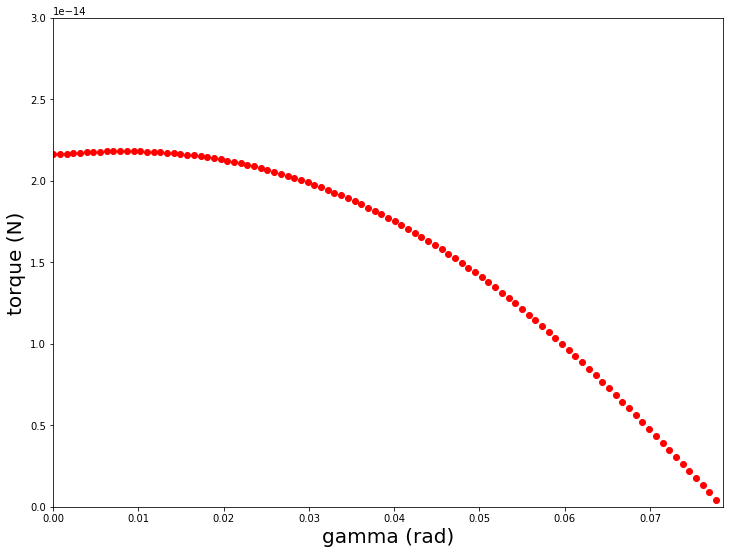

In [92]:
"""Main function"""
step = seperation_angle(n) #angle between each QD, angle required for one step
angle_increment = step/100 #angle to be incremented when producing torque function 
PCs = permanent_charges( Rp, p , cap_d, cap_vol, w, r) #initializes permanent charges

"""Graph of torque function to be approximated"""
fig = plt.figure(figsize=(12, 9))
ax1 = fig.add_subplot(111)
ax1.set_xlabel('gamma (rad)', fontsize = '20')
ax1.set_ylabel('torque (N)', fontsize = '20')
ax1.set_xlim( 0 , step )
ax1.set_ylim( 0 , 3e-14)

"""Computation of 'true' torque """
i = 0
T = []
gamma_list = []
for gamma in np.arange(0, step, angle_increment): #iterates angle increment until one step is completed
    gamma_list.append( gamma ) #list storing values of the angle
    F_t = tangential_component(k , n, e, R, Rp, gamma, noc, w, r) #determines tangential component of Coulomb force
    T.append( torque(F_t, Rp, p, r) ) #calculates torque acting on inner rotor
    ax1.scatter(gamma, T[i] , color = 'r') #plots torque vs angle rotated
    i += 1 #needed to keep track of T array

plt.show()

In [93]:
"""Scaling to make approxiamtion more accurate"""
for i in np.arange( 0, int(step/angle_increment) ):
    T[i] = T[i] * 1e14

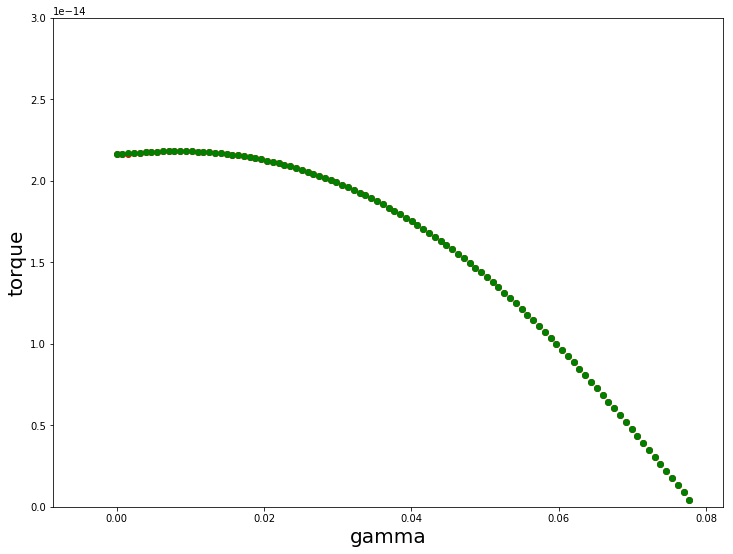

In [94]:
"""Approximate torque function"""
popt, pcov = curve_fit(func, gamma_list, T) #fits curve to previously calculated torque using func
'''Output constants'''
AA = popt[0] * 1e-14
BB = popt[1] * 1e-14
CC = popt[2] * 1e-14
DD = popt[3] * 1e-14
EE = popt[4] * 1e-14
FF = popt[5] * 1e-14
GG = popt[6] * 1e-14
HH = popt[7] * 1e-14
A = popt[8] * 1e-14
B = popt[9] * 1e-14
C = popt[10] * 1e-14
D = popt[11] * 1e-14
E = popt[12] * 1e-14
F = popt[13] * 1e-14
G = popt[14] * 1e-14
H = popt[15] * 1e-14
J = popt[16] * 1e-14
K = popt[17] * 1e-14
L = popt[18] * 1e-14
M = popt[19] * 1e-14
O = popt[20] * 1e-14
P = popt[21] * 1e-14
S = popt[22] * 1e-14
U = popt[23] * 1e-14

"""Rescaling"""
for i in np.arange( 0, int(step/angle_increment) ):
    T[i] = T[i] * 1e-14

'''Plots original torque function and fitted torque function on same graph'''
fig2 = plt.figure(figsize=(12, 9))
bx1 = fig2.add_subplot(111)
bx2 = fig2.add_subplot(111)
bx1.set_xlabel('gamma', fontsize = '20')
bx1.set_ylabel('torque', fontsize = '20')
bx1.set_ylim( 0 , 3e-14)
for i in np.arange( 0, int(step/angle_increment) ):
    bx1.scatter( gamma_list[i], T[i], color = 'r' )
    bx2.scatter( gamma_list[i], ( func(gamma_list[i], AA, BB, CC, DD, EE, FF, GG, HH, A, B, C, D, E, F, G, H, J, K, L, M, O, P, S, U) ), color= 'g' )
plt.show()

In [95]:
print step

0.0785398163397


In [96]:
"""Solve ODE for motor with viscous drag and Brownian force"""
tStop = 2.7e-3
tInc = 1e-6
t_array = np.arange( 0, tStop, tInc)
initial_sol = [0, 0]
complete_sol = np.zeros((len(t_array),2))
i = 0
for time in np.arange(0, tStop, 2*tInc):
    fb_t = 0
    for dt in np.arange(0, tInc, tStep_max):
        accepted = 0
        while(accepted == 0):
            fb = rand_fb(kb, temp, atm, no, tStep_max, p)
            ffb = prob_dist_fb(kb, temp, atm, no, tStep_max, fb, p) #probability of fb
            rffb = rand_ffb(kb, temp, atm, no, tStep_max, fb, p) #random number between 0 and peak probability
            if (rffb <= ffb): #if random number <= probability of fb, than accept fb
                accepted = 1
        fb_t += fb
    print(fb_t)
    Utemp = U + fb_t
    params = [ (constant*((Rp-(r/4))/2))/I , AA/I, BB/I, CC/I, DD/I, EE/I, FF/I, GG/I, HH/I, A/I, B/I, C/I, D/I, E/I, F/I, G/I, H/I, J/I, K/I, L/I, M/I, O/I, P/I, S/I, Utemp/I ]
    sol = odeint( solvr, [initial_sol[0], initial_sol[1]], [ t_array[i], t_array[i+1] ], args=(params,) )
    initial_sol[0] = sol[1][0]
    initial_sol[1] = sol[1][1]
    complete_sol[i][0] = sol[0][0]
    complete_sol[i][1] = sol[0][1]
    complete_sol[i+1][0] = sol[1][0]
    complete_sol[i+1][1] = sol[1][1]
    print(t_array[i], sol[0][0])
    i += 2

3.55107442283e-28
(0.0, 0.0)
-6.08483154597e-28
(1.9999999999999999e-06, 6.0117332097713039e-05)
2.35051033471e-29
(3.9999999999999998e-06, 0.00012023888265964025)
1.55325726005e-28
(6.0000000000000002e-06, 0.00018036315082378934)
3.2985899838e-28
(7.9999999999999996e-06, 0.00024049193114211557)
4.10233523592e-28
(9.9999999999999991e-06, 0.00030062432800918057)
4.49558366128e-29
(1.2e-05, 0.00036076034341239673)
-9.26411224746e-28
(1.4e-05, 0.00036080694001034628)
-1.98556666093e-27
(1.5999999999999999e-05, 0.00042094657694735936)
-5.02936545097e-28
(1.8e-05, 0.0004810891922394419)
-3.90714007857e-28
(1.9999999999999998e-05, 0.00054123509391862509)
-4.80964651328e-28
(2.1999999999999999e-05, 0.00060138558787419666)
-9.95528489698e-29
(2.4000000000000001e-05, 0.0006615397010186168)
-2.96748268075e-28
(2.5999999999999998e-05, 0.00072169743555439657)
-9.48782722055e-28
(2.8e-05, 0.00078185879061175767)
-1.39338832839e-28
(2.9999999999999997e-05, 0.00084202377421091794)
-5.74502787646e-28


-1.56613682262e-27
(0.00026600000000000001, 0.0071197438423329668)
-1.62013090343e-28
(0.00026800000000000001, 0.0071802923196428569)
-1.69008048994e-28
(0.00027, 0.0072408444676702122)
-2.86471963181e-28
(0.000272, 0.0073014002870026495)
-1.22708385543e-27
(0.00027399999999999999, 0.007361959778223604)
6.67719593121e-28
(0.00027599999999999999, 0.0074225229419206742)
1.27661179453e-27
(0.00027799999999999998, 0.0074830897786805446)
4.32416032436e-28
(0.00027999999999999998, 0.0075436602890986571)
1.96187630012e-28
(0.00028199999999999997, 0.0076042344737697453)
2.67500904026e-28
(0.00028399999999999996, 0.0076648123332901611)
1.93774929145e-28
(0.00028600000000000001, 0.0077253938683964898)
1.45934805692e-27
(0.00028800000000000001, 0.0077859790796981094)
2.17827583955e-28
(0.00029, 0.0078465679677754072)
1.25847098318e-27
(0.000292, 0.00790716053320893)
-2.57962826042e-28
(0.00029399999999999999, 0.0079677567765794443)
8.10642065047e-29
(0.00029599999999999998, 0.0080283575972582202)

2.8661702999e-28
(0.00052799999999999993, 0.0150833362195392)
5.29104376346e-28
(0.00052999999999999998, 0.015144374883548783)
4.03688225711e-29
(0.00053200000000000003, 0.015205417332371173)
-3.4253663663e-28
(0.00053399999999999997, 0.015266463563242785)
1.48980303478e-27
(0.00053600000000000002, 0.015327513583436418)
5.01434748554e-28
(0.00053799999999999996, 0.015388567384546843)
5.86729314308e-28
(0.00054000000000000001, 0.015449624970809133)
3.67997673397e-28
(0.00054199999999999995, 0.015510686346980121)
2.36175025276e-28
(0.000544, 0.015571751512589924)
-9.95411890747e-29
(0.00054599999999999994, 0.015632820466864275)
-1.63625245208e-27
(0.00054799999999999998, 0.015693893205344506)
-6.46163038728e-28
(0.00054999999999999992, 0.015754969737195826)
8.66713812525e-28
(0.00055199999999999997, 0.015816050057037487)
7.95019636021e-28
(0.00055400000000000002, 0.015877134168018035)
-6.99075731077e-28
(0.00055599999999999996, 0.015938222070590084)
-4.84817387473e-28
(0.0005580000000000

7.85361104686e-28
(0.00078599999999999991, 0.022988806944305849)
-7.52491110309e-28
(0.00078799999999999996, 0.023050339534375259)
4.84614316005e-29
(0.00079000000000000001, 0.023111875996007714)
-4.30448019116e-28
(0.00079199999999999995, 0.02317341633928242)
-9.65864030447e-28
(0.000794, 0.02323496055482345)
-4.77063737485e-28
(0.00079599999999999994, 0.023296508656829827)
7.07171333594e-28
(0.00079799999999999999, 0.023358060634530654)
1.43405463754e-28
(0.00079999999999999993, 0.023419616485391828)
-1.52408856581e-27
(0.00080199999999999998, 0.023419660395390951)
5.76935365203e-28
(0.00080399999999999992, 0.023481220135485755)
-8.58101341197e-28
(0.00080599999999999997, 0.023481264226765355)
-9.04189827845e-29
(0.00080800000000000002, 0.023542827850589122)
5.21831330786e-28
(0.00080999999999999996, 0.023542872143855836)
-1.83502851518e-28
(0.000812, 0.02360443965284386)
1.68488854805e-27
(0.00081399999999999994, 0.023604484144946099)
-5.53356258856e-28
(0.00081599999999999999, 0.02

-1.24862138403e-27
(0.0010460000000000001, 0.028049744681617961)
5.80029118407e-29
(0.0010479999999999999, 0.028111597231733308)
2.05094735881e-27
(0.0010499999999999999, 0.028173453711763028)
4.22276563853e-29
(0.001052, 0.028235314122467017)
6.35731419469e-28
(0.001054, 0.02829717846468242)
1.82833561249e-27
(0.0010559999999999999, 0.028359046739046885)
-1.2772382356e-27
(0.0010579999999999999, 0.02842091894631513)
-3.33258216839e-28
(0.00106, 0.028482795087327688)
-8.93704206108e-29
(0.001062, 0.028544675162694589)
7.53638656822e-29
(0.0010640000000000001, 0.028606559173218367)
1.39747308818e-27
(0.0010659999999999999, 0.028668447119648617)
-1.3827554882e-28
(0.0010679999999999999, 0.028730339002711214)
2.83679271107e-28
(0.00107, 0.028792234823223871)
2.58301953804e-28
(0.001072, 0.028854134581866305)
-1.71352435235e-27
(0.0010739999999999999, 0.028916038279416561)
1.51491105751e-27
(0.0010759999999999999, 0.028977945916660353)
-6.11997257624e-28
(0.001078, 0.029039857494235714)
-5

1.9516756545e-27
(0.001328, 0.036810131475520341)
8.93765741757e-28
(0.00133, 0.036872546286744551)
-1.03641074367e-27
(0.0013319999999999999, 0.036934965146087802)
9.81338856711e-28
(0.0013339999999999999, 0.036997388054341981)
1.51887078387e-28
(0.0013359999999999999, 0.037059815012300053)
-7.13426823626e-28
(0.001338, 0.03712224602075468)
-9.31744078942e-28
(0.00134, 0.037184681080498931)
3.36294484454e-28
(0.0013419999999999999, 0.037247120192326351)
-1.27701934199e-27
(0.0013439999999999999, 0.037309563357030368)
-1.37891842992e-27
(0.001346, 0.037372010575404895)
-8.199555869e-28
(0.001348, 0.037434461848244151)
9.89769097485e-28
(0.0013499999999999999, 0.037496917176342501)
-6.51993323726e-29
(0.0013519999999999999, 0.037559376560494476)
-6.52781523605e-28
(0.001354, 0.037621840001495169)
8.28985574741e-28
(0.001356, 0.037684307500139659)
1.22722000063e-27
(0.0013579999999999998, 0.037746779057223456)
9.59533222556e-28
(0.0013599999999999999, 0.037809254673542118)
-4.48943860308

2.97604600835e-29
(0.0016099999999999999, 0.045650973514263449)
5.82638807334e-28
(0.0016119999999999999, 0.045713968211160624)
-1.33280791678e-27
(0.001614, 0.045776965313011009)
-1.31861212129e-27
(0.001616, 0.045839968327800552)
2.1880436618e-28
(0.0016179999999999999, 0.045902973744681171)
-3.18847606816e-28
(0.0016199999999999999, 0.045965985080674336)
1.01204638513e-27
(0.001622, 0.046028998815897518)
4.12376104985e-28
(0.001624, 0.046092018476389898)
2.19185989638e-29
(0.0016259999999999998, 0.046155040533217576)
-1.52993653156e-27
(0.0016279999999999999, 0.046218068521522916)
7.02947411115e-28
(0.0016299999999999999, 0.046281098903353683)
1.67438190729e-28
(0.001632, 0.046344134389380461)
-9.28881874162e-28
(0.0016339999999999998, 0.046407173916307672)
1.47783057691e-27
(0.0016359999999999999, 0.046470216911548443)
-2.89351996892e-28
(0.0016379999999999999, 0.046533264899184898)
-4.67753374558e-28
(0.00164, 0.046596317024658641)
5.02141131756e-28
(0.001642, 0.046659373515251706

1.4764159021e-27
(0.0018859999999999999, 0.054383785483523357)
5.34744840974e-29
(0.0018879999999999999, 0.05444736113947634)
2.70503323279e-28
(0.00189, 0.054510941070435651)
-8.55459929223e-28
(0.001892, 0.054574525277041923)
-1.73339052802e-28
(0.0018939999999999999, 0.054638113760443731)
-6.71224723521e-28
(0.0018959999999999999, 0.054701706522104536)
1.21897838009e-27
(0.0018979999999999999, 0.054765303561050943)
1.36576166303e-28
(0.0019, 0.054828904880216613)
-2.59983754565e-28
(0.0019019999999999998, 0.054892510478612967)
9.63792032441e-28
(0.0019039999999999999, 0.054956120358224052)
2.85886818959e-29
(0.0019059999999999999, 0.055019734519360812)
1.11700025038e-27
(0.001908, 0.055083352962704953)
-5.49381070246e-28
(0.0019099999999999998, 0.055146975692339908)
-3.30251864664e-28
(0.0019119999999999999, 0.055210602703844175)
-3.90690588348e-28
(0.0019139999999999999, 0.055274234001287052)
-7.91081391645e-28
(0.001916, 0.055337869586310935)
-2.04353231552e-28
(0.001918, 0.055401

5.32176708551e-28
(0.0021559999999999999, 0.063005515557144717)
1.45966291568e-28
(0.0021579999999999998, 0.063069676248235756)
-3.45320072314e-29
(0.00216, 0.063133841332345383)
1.57640553659e-27
(0.0021619999999999999, 0.063198010811783514)
2.8168012844e-28
(0.0021639999999999997, 0.063262184685656461)
-9.39410765622e-28
(0.002166, 0.063326362958034163)
9.2539880934e-28
(0.0021679999999999998, 0.063390545627006453)
7.51165739085e-28
(0.0021700000000000001, 0.063454732694932819)
6.50610155506e-28
(0.0021719999999999999, 0.063518924161055729)
-1.75517276331e-28
(0.0021739999999999997, 0.063583120028930545)
-5.16040648023e-28
(0.002176, 0.063647320300493887)
-1.24003646397e-27
(0.0021779999999999998, 0.063711524971865344)
-2.94769508702e-28
(0.0021800000000000001, 0.063775734047596025)
5.64562275948e-29
(0.0021819999999999999, 0.063839947524517243)
-6.29184511073e-28
(0.0021839999999999997, 0.063904165411267616)
6.90903532692e-28
(0.002186, 0.063968387701358348)
2.90217303771e-29
(0.002

2.08011203021e-28
(0.0024239999999999999, 0.071642561333383911)
1.0034920283e-27
(0.0024259999999999998, 0.071707318989969696)
1.57882421145e-28
(0.002428, 0.071772081165557347)
2.4057468941e-28
(0.0024299999999999999, 0.071836847860879238)
5.20623980247e-28
(0.0024319999999999997, 0.071901619076276596)
-1.62160888581e-27
(0.002434, 0.071966394807099696)
-7.69749297945e-28
(0.0024359999999999998, 0.072031175066723269)
1.62593487432e-28
(0.0024380000000000001, 0.072095959842099974)
-1.59868916415e-28
(0.0024399999999999999, 0.072160749147373457)
6.57463694505e-28
(0.0024419999999999997, 0.072225542974131821)
-4.61450938839e-28
(0.002444, 0.072290341325247615)
8.13156294359e-28
(0.0024459999999999998, 0.072355144204575145)
-7.58511812431e-28
(0.0024480000000000001, 0.072419951613096376)
1.22839894868e-27
(0.0024499999999999999, 0.072484763547072353)
1.2095150773e-27
(0.0024519999999999998, 0.072549580008992559)
-6.39112543385e-28
(0.002454, 0.07261440100316062)
-8.8884898771e-29
(0.00245

9.63522383536e-28
(0.0026919999999999999, 0.080360721215239794)
-1.87471699157e-28
(0.0026939999999999998, 0.080426092827270312)
-3.09880150366e-28
(0.002696, 0.080491469083757289)
2.72081895125e-28
(0.0026979999999999999, 0.080556849984882453)
4.98213240677e-28


IndexError: index 2701 is out of bounds for axis 0 with size 2701

In [ ]:
keep_i = 0
for i in np.arange( 0, len(t_array) ):
    if complete_sol[i][0] >= step:
        keep_i = i
        break
    else:
        keep_i = len(t_array)

print (step)
print (len(t_array))
print (keep_i)
snipped_sol = np.zeros((keep_i, 2))
snipped_sol = complete_sol[:keep_i]

In [ ]:
"""Plot solution"""
fig3 = plt.figure(figsize=(12, 9))
cx1 = fig3.add_subplot(211)
cx1.set_xlabel('time')
cx1.set_ylabel('gamma')
cx1.set_ylim( 0 , step )
cx1.set_xlim( 0 , t_array[keep_i-1] )
cx2 = fig3.add_subplot(212)
cx2.set_xlabel('time')
cx2.set_ylabel('w')
cx2.set_ylim( 0 , 200 )
cx2.set_xlim( 0 , t_array[keep_i-1] )
for i in np.arange( 0, len(snipped_sol) ):
    cx1.scatter( t_array[i], snipped_sol[i][0], color='r' )
    cx2.scatter( t_array[i], snipped_sol[i][1], color='b' )
plt.show()